<a href="https://colab.research.google.com/github/VanesaHM/ProyectoKaggle/blob/main/05_modelo_con_preprocesado_(KNNImputer%2C_OHE%2C_StandardScaler%2C_SMOTE)_y_Red_Neuronal_(Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia**

Crear un modelo para predecir el rendimiento de los estudiantes en las pruebas Saber Pro

# **Descripción general**

Las Pruebas Saber Pro son exámenes estandarizados que se administran en Colombia para evaluar la calidad y el nivel de conocimiento y competencias de los estudiantes de educación superior, es decir, de instituciones de educación superior como universidades y tecnológicos. Estas pruebas son parte de los esfuerzos del Gobierno de Colombia para monitorear y mejorar la calidad de la educación superior en el país.

Estas Pruebas constan cinco componentes genéricos, Inglés, Lectura Crítica, Competencias Ciudadanas, Razonamiento Cuantitativo y Comunicación Escrita.

Tu tarea será crear un modelo de clasificación que para cada estudiante prediga qué desempeño va a tener: bajo, medio-bajo, medio-alto o alto.

# **Descripción**

El conjunto de datos contiene más de 50 columnas que describen de manera distintos aspectos de cada estudiante, incluyendo:

Información socieconómica: Describen características socieconómicas del estudiante como su estrato, educación de sus padres, estrato, entre otras.

Información de instituciones: Describen las instituciones de donde provienen los estudiantes.

Información del estudiante: Describe particularidades del estudiante como su edad, que programa estudian, la modalidad de estudio, etc.

Información estadística: Describe algunos coeficientes que equipos de estudio han desarrollado que podría ayudar a la clasificación.

Así como muchos otros datos que ayudan a clasificar de manera precisa los niveles de desempeño

# **modelo con preprocesado (KNNImputer, OHE, StandardScaler, SMOTE) y Red Neuronal (Keras)**



**1. Importar librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import time


**2. Configuración visual**

In [ ]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

**3. Cargar los datos**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.26GB/s]


**4. Descomprimir los datos**

In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
train = pd.read_csv("train.csv")
test  = pd.read_csv('test.csv')

# **ANÁLISIS EXPLORATORIO INICIAL**

Se muestran las primeras filas, tipos y valores nulos.

In [ ]:
if train is not None:
    display(train.head())
    display(train.info())
    display(train.isna().sum().sort_values(ascending=False).head(20))
else:
    print('No train available to display.')

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

None

,0
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498


# **PREPROCESAMIENTO**


🚀 NOTEBOOK 5: NEURAL NETWORK - PREPROCESAMIENTO → ENTRENAMIENTO → KAGGLE


SECCIÓN 1: PREPROCESAMIENTO MEJORADO CON FEATURE ENGINEERING

📊 Filas originales: 692,500
⚡ Stratified sampling al 50%...
✓ Filas después: 346,250
✓ Numéricas: 5 | Categóricas: 13
✓ Imputación completada
✓ Outliers cappeados

🔧 FEATURE ENGINEERING:
  ✓ +6 features de ingeniería

📊 Features numéricas totales: 12
✓ Train/Test split: 277,000 / 69,250
✓ Features finales: 152
✓ Classes: {'alto': 0, 'bajo': 1, 'medio-alto': 2, 'medio-bajo': 3}
✓ Balanceo aceptable (ratio: 1.02)

✅ PREPROCESAMIENTO COMPLETADO


SECCIÓN 2: ENTRENAMIENTO CON NEURAL NETWORK

🧠 NEURAL NETWORK ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,324 (329.39 KB)

 Trainable params: 83,428 (325.89 KB)

 Non-trainable params: 896 (3.50 KB)

None

⏳ Entrenando Neural Network...
✓ Entrenamiento completado

🎯 Prediciendo en TEST...

📊 RESULTADOS NEURAL NETWORK:
  Accuracy:  0.4193
  F1-Score:  0.4070

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto     0.5206    0.6350    0.5721     17562
        bajo     0.4525    0.5199    0.4839     17299
  medio-alto     0.3128    0.2224    0.2600     17162
  medio-bajo     0.3223    0.2947    0.3079     17227

    accuracy                         0.4193     69250
   macro avg     0.4020    0.4180    0.4060     69250
weighted avg     0.4028    0.4193    0.4070     69250



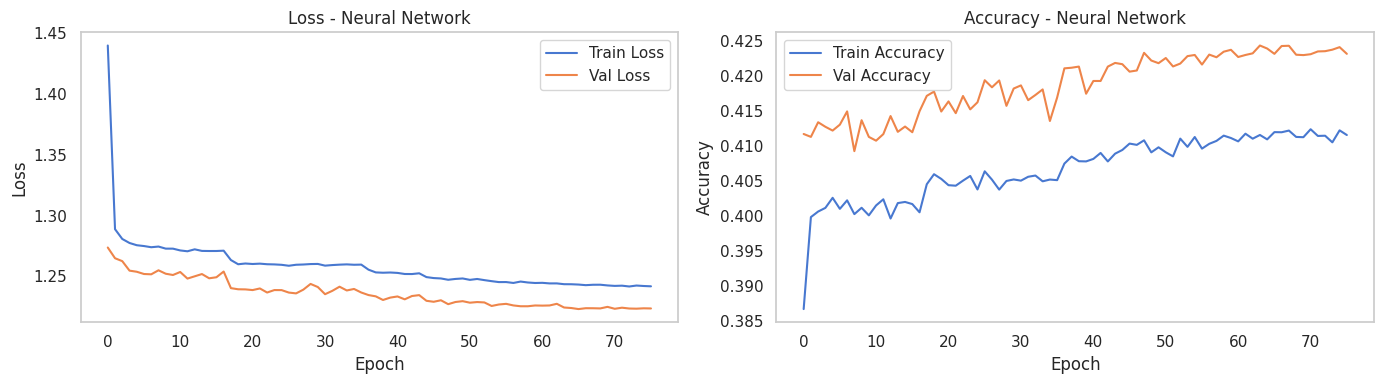

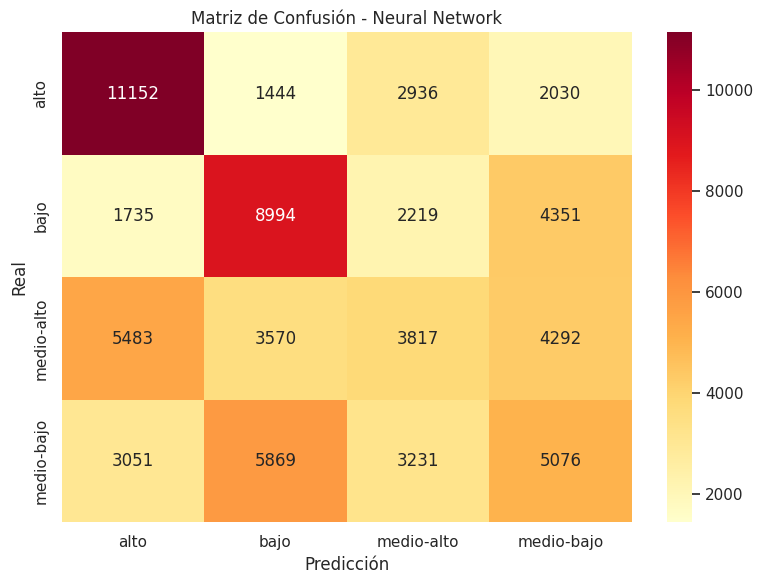


💾 Guardando modelo...
✅ ENTRENAMIENTO COMPLETADO


SECCIÓN 3: PREDICCIÓN EN DATASET COMPLETO PARA KAGGLE

📂 Cargando dataset original sin samplear...
✓ Test original shape: (296786, 20)
✓ Test preprocesado y feature engineering aplicado
✓ Transformaciones aplicadas: (296786, 152)

🔮 Haciendo predicciones en 296,786 muestras...
✓ Predicciones completadas

📊 Distribución de predicciones:
  alto: 92,524 (31.2%)
  bajo: 85,335 (28.8%)
  medio-alto: 51,299 (17.3%)
  medio-bajo: 67,628 (22.8%)

💾 Guardando submission.csv...

✅ LISTO PARA ENVIAR A KAGGLE
✓ Archivo: submission_neural_network.csv
✓ Filas: 296,786
✓ Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

    ID RENDIMIENTO_GLOBAL
550236         medio-alto
 98545         medio-alto
499179               alto
782980               bajo
785185               bajo
 58495         medio-bajo
705444               alto
557548               alto
519909               bajo
832058               alto

⏱️  Tiempo total: 95.92 minutos


In [ ]:
print("\n\n" + "="*70)
print("PREPROCESAMIENTO")
print("="*70)

train_processed = train.copy()
inicio_total = time.time()

ID_COL = "ID"
TARGET = "RENDIMIENTO_GLOBAL"
NUM_VARS = ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
ESTRATO_MAP = {f'Estrato {i}': i for i in range(1, 7)}
REVERSE_ESTRATO = {v: k for k, v in ESTRATO_MAP.items()}
TEST_SIZE = 0.2
RANDOM_STATE = 42
SAMPLE_FRAC = 0.5

print(f"\nFilas originales: {len(train_processed):,}")

# SAMPLING
if len(train_processed) > 200000:
    print(f"Stratified sampling al {SAMPLE_FRAC*100:.0f}%...")
    train_sample, _ = train_test_split(
        train_processed, train_size=SAMPLE_FRAC, random_state=RANDOM_STATE,
        stratify=train_processed[TARGET]
    )
    train_processed = train_sample.reset_index(drop=True)
    print(f"Filas después: {len(train_processed):,}")

# LIMPIEZA
cols_drop = [c for c in train_processed.columns if ".1" in c]
train_processed.drop(columns=cols_drop, inplace=True, errors='ignore')
cat_vars = [c for c in train_processed.columns if c not in NUM_VARS + [ID_COL, TARGET]]

print(f"Numéricas: {len(NUM_VARS)} | Categóricas: {len(cat_vars)}")

# IMPUTACIÓN F_ESTRATOVIVIENDA
if "F_ESTRATOVIVIENDA" in train_processed.columns:
    socio_vars = [
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA',
        'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE',
        'E_VALORMATRICULAUNIVERSIDAD'
    ]
    socio_vars = [v for v in socio_vars if v in train_processed.columns]

    temp = train_processed[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})

    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    train_processed["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=train_processed.index).map(REVERSE_ESTRATO)
    del temp, imputer, imputado

# IMPUTACIÓN CATEGÓRICAS
for col in cat_vars:
    if train_processed[col].isnull().sum() > 0:
        fill_value = train_processed[col].mode()[0] if train_processed[col].nunique() <= 3 else "Desconocido"
        train_processed[col] = train_processed[col].fillna(fill_value)

print("Imputación completada")

# OUTLIERS
for col in NUM_VARS:
    p1, p99 = train_processed[col].quantile([0.01, 0.99])
    train_processed[col] = train_processed[col].clip(p1, p99)

print("Outliers cappeados")

# FEATURE ENGINEERING
print("\nFEATURE ENGINEERING:")

train_processed['PROMEDIO_INDICADORES'] = train_processed[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].mean(axis=1)
train_processed['STD_INDICADORES'] = train_processed[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].std(axis=1)

max_ind = train_processed[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].max(axis=1)
min_ind = train_processed[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].min(axis=1)
train_processed['RANGO_INDICADORES'] = max_ind - min_ind

activos = ['F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA', 'F_TIENEINTERNET']
activos_disponibles = [a for a in activos if a in train_processed.columns]

def contar_activos(row):
    return sum(1 for col in activos_disponibles if row.get(col) == 'Si')

train_processed['NUM_ACTIVOS'] = train_processed[activos_disponibles].apply(contar_activos, axis=1)

if 'E_HORASSEMANATRABAJA' in train_processed.columns:
    horas_map = {'0': 0, 'Menos de 10': 5, 'Entre 10 y 20': 15,
                 'Entre 20 y 30': 25, 'Más de 30 horas': 35}
    train_processed['HORAS_TRABAJO_NUM'] = train_processed['E_HORASSEMANATRABAJA'].map(horas_map).fillna(0)
    train_processed['INDICADORES_X_TRABAJO'] = train_processed['PROMEDIO_INDICADORES'] / (train_processed['HORAS_TRABAJO_NUM'] + 1)

educacion_map = {
    'Primaria incompleta': 1, 'Primaria completa': 2,
    'Secundaria incompleta': 2.5, 'Secundaria completa': 3,
    'Educación profesional incompleta': 3.5, 'Educación profesional completa': 4,
    'Postgrado': 5
}

if 'F_EDUCACIONPADRE' in train_processed.columns and 'F_EDUCACIONMADRE' in train_processed.columns:
    padre = train_processed['F_EDUCACIONPADRE'].map(educacion_map).fillna(2)
    madre = train_processed['F_EDUCACIONMADRE'].map(educacion_map).fillna(2)
    train_processed['EDUCACION_PADRES_SCORE'] = (padre + madre) / 2

print("Feature engineering completado")

NUM_VARS_NEW = NUM_VARS + [
    'PROMEDIO_INDICADORES', 'STD_INDICADORES', 'RANGO_INDICADORES',
    'NUM_ACTIVOS', 'HORAS_TRABAJO_NUM', 'INDICADORES_X_TRABAJO',
    'EDUCACION_PADRES_SCORE'
]
NUM_VARS_NEW = [v for v in NUM_VARS_NEW if v in train_processed.columns]

print(f"\nFeatures numéricas totales: {len(NUM_VARS_NEW)}")

# TRAIN/TEST SPLIT
X = train_processed[NUM_VARS_NEW + cat_vars]
y = train_processed[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

del train_processed, X, y
print(f"Train/Test split: {len(X_train):,} / {len(X_test):,}")

# TRANSFORMACIONES
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_VARS_NEW),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, max_categories=50), cat_vars)
    ],
    remainder="drop"
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

cat_ohe_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_vars)
final_cols = NUM_VARS_NEW + list(cat_ohe_cols)

print(f"Features finales: {len(final_cols)}")

# CODIFICAR TARGET
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

# BALANCEAR CON SMOTE
class_counts = np.bincount(y_train_encoded)
imbalance_ratio = class_counts.max() / class_counts.min()

if imbalance_ratio > 2.5:
    print(f"Aplicando SMOTE (ratio: {imbalance_ratio:.2f})...")
    smote = SMOTE(random_state=RANDOM_STATE, n_jobs=-1, k_neighbors=3, sampling_strategy='not majority')
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_encoded)
else:
    print(f"Balanceo aceptable (ratio: {imbalance_ratio:.2f})")
    X_train_balanced, y_train_balanced = X_train_processed, y_train_encoded

print("\nPREPROCESAMIENTO COMPLETADO\n")

# **ENTRENAMIENTO CON NEURAL NETWORK**

In [ ]:
# Convertir sparse a dense para Keras
if hasattr(X_train_balanced, 'toarray'):
    X_train_balanced = X_train_balanced.toarray()
    X_test_processed = X_test_processed.toarray()

print("\nNEURAL NETWORK ARCHITECTURE")
print("="*70)

# Crear modelo
model = keras.Sequential([
    layers.Input(shape=(X_train_balanced.shape[1],)),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),

    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenar
print("\nEntrenando Neural Network...")
history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print("Entrenamiento completado")

# PREDICCIONES
print("\nPrediciendo en TEST...")
y_pred_proba = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# MÉTRICAS
acc_nn = accuracy_score(y_test_encoded, y_pred)
f1_nn = f1_score(y_test_encoded, y_pred, average='weighted')

print("\nRESULTADOS NEURAL NETWORK:")
print(f"  Accuracy:  {acc_nn:.4f}")
print(f"  F1-Score:  {f1_nn:.4f}")

print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, digits=4))

# GRÁFICAS
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss - Neural Network')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Accuracy - Neural Network')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# MATRIZ DE CONFUSIÓN
cm = confusion_matrix(y_test_encoded, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax.set_title('Matriz de Confusión - Neural Network')
ax.set_ylabel('Real')
ax.set_xlabel('Predicción')
plt.tight_layout()
plt.show()

# GUARDAR MODELO
print("\nGuardando modelo...")
model.save('neural_network_model.h5')
with open("preprocessor_nn.pkl", "wb") as f:
    pickle.dump(preprocessor, f)
with open("label_encoder_nn.pkl", "wb") as f:
    pickle.dump(le, f)

print("ENTRENAMIENTO COMPLETADO\n")


# **PREDICCIÓN EN DATASET COMPLETO**

In [ ]:
print("\nCargando dataset original sin samplear...")
test_proc = test.copy()

print(f"Test original shape: {test_proc.shape}")

# PREPROCESAR TEST (igual que train)
cols_drop = [c for c in test_proc.columns if ".1" in c]
test_proc.drop(columns=cols_drop, inplace=True, errors='ignore')

if "F_ESTRATOVIVIENDA" in test_proc.columns:
    socio_vars = [v for v in socio_vars if v in test_proc.columns]
    temp = test_proc[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})
    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    test_proc["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=test_proc.index).map(REVERSE_ESTRATO)
    del temp, imputer, imputado

for col in cat_vars:
    if test_proc[col].isnull().sum() > 0:
        fill_value = test_proc[col].mode()[0] if test_proc[col].nunique() <= 3 else "Desconocido"
        test_proc[col] = test_proc[col].fillna(fill_value)

for col in NUM_VARS_NEW[:5]:
    p1, p99 = test_proc[col].quantile([0.01, 0.99])
    test_proc[col] = test_proc[col].clip(p1, p99)

# Feature engineering en test
test_proc['PROMEDIO_INDICADORES'] = test_proc[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].mean(axis=1)
test_proc['STD_INDICADORES'] = test_proc[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].std(axis=1)
test_proc['RANGO_INDICADORES'] = (
    test_proc[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].max(axis=1) -
    test_proc[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].min(axis=1)
)
test_proc['NUM_ACTIVOS'] = test_proc[activos_disponibles].apply(contar_activos, axis=1)

if 'E_HORASSEMANATRABAJA' in test_proc.columns:
    test_proc['HORAS_TRABAJO_NUM'] = test_proc['E_HORASSEMANATRABAJA'].map(horas_map).fillna(0)
    test_proc['INDICADORES_X_TRABAJO'] = test_proc['PROMEDIO_INDICADORES'] / (test_proc['HORAS_TRABAJO_NUM'] + 1)

padre = test_proc['F_EDUCACIONPADRE'].map(educacion_map).fillna(2)
madre = test_proc['F_EDUCACIONMADRE'].map(educacion_map).fillna(2)
test_proc['EDUCACION_PADRES_SCORE'] = (padre + madre) / 2

print("Test preprocesado y feature engineering aplicado")

# TRANSFORMAR
X_test_full = test_proc[NUM_VARS_NEW + cat_vars]
X_test_full_processed = preprocessor.transform(X_test_full)

if hasattr(X_test_full_processed, 'toarray'):
    X_test_full_processed = X_test_full_processed.toarray()

print(f"Transformaciones aplicadas: {X_test_full_processed.shape}")

# PREDECIR
print(f"\nHaciendo predicciones en {len(X_test_full):,} muestras...")
y_pred_proba_full = model.predict(X_test_full_processed, verbose=0)
y_pred_full = le.inverse_transform(np.argmax(y_pred_proba_full, axis=1))

print("Predicciones completadas")


# **CREAR SUBMISSION**

In [ ]:
submission = pd.DataFrame({
    'ID': test_proc[ID_COL].values,
    'RENDIMIENTO_GLOBAL': y_pred_full
})

print("\nDistribución de predicciones:")
for cls in le.classes_:
    count = (y_pred_full == cls).sum()
    pct = count / len(y_pred_full) * 100
    print(f"  {cls}: {count:,} ({pct:.1f}%)")

# Guardar archivo
print("\nGuardando submission.csv...")
submission.to_csv('submission_neural_network.csv', index=False)

print("\n" + "="*70)
print(f"Archivo: submission_neural_network.csv")
print(f"Filas: {len(submission):,}")
print(f"Columnas: {list(submission.columns)}")

print("\n" + submission.head(10).to_string(index=False))

tiempo_total = time.time() - inicio_total
print(f"\nTiempo total: {tiempo_total/60:.2f} minutos")
print("="*70)

In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f submission_neural_network.csv -m "NEURAL NETWORK"

100% 4.05M/4.05M [00:00<00:00, 5.71MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia